In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np
import sys
import astropy.units as u
from astropy.io import ascii, fits
from astropy.modeling.blackbody import blackbody_lambda

sys.path.insert(0, '../')
from libra import Spot, Star

In [27]:
phoenix = fits.getdata('../libra/data/phoenix/lte026.0-4.5-0.0a+0.0.BT-Settl.spec.fits')

kplr = ascii.read('../libra/data/filters/kepler_response_hires1.txt')
kplr_wavelength, kplr_trans = kplr['col1'], kplr['col2']

phoenix_wavelength = phoenix['Wavelength']*1000 * u.nm
phoenix_flux = phoenix['Flux'] / phoenix['Flux'].max()

cut_wavelengths = (phoenix_wavelength < 200*u.nm) | (phoenix_wavelength > 6000*u.nm)
phoenix_wavelength = phoenix_wavelength[~cut_wavelengths]
phoenix_flux = phoenix_flux[~cut_wavelengths]

kplr = ascii.read('../libra/data/filters/kepler_response_hires1.txt')

bb_2559 = blackbody_lambda(phoenix_wavelength, 2559)
bb_2600 = blackbody_lambda(phoenix_wavelength, 2600)

trappist1_flux = phoenix_flux * bb_2559.value / bb_2600.value

spitz_1 = ascii.read('../libra/data/filters/Spitzer_IRAC.I1.txt')
spitz1_wave = (spitz_1['col1'] * u.Angstrom).to(u.nm)
spitz1_trans = spitz_1['col2']

spitz_2 = ascii.read('../libra/data/filters/Spitzer_IRAC.I2.txt')
spitz2_wave = (spitz_2['col1'] * u.Angstrom).to(u.nm)
spitz2_trans = spitz_2['col2']

from libra import throughput

In [28]:
phoenix_wavelength

<Quantity [  200.        ,  200.00498962,  200.00999451,...,
            5999.89990234, 5999.94970703, 6000.        ] nm>

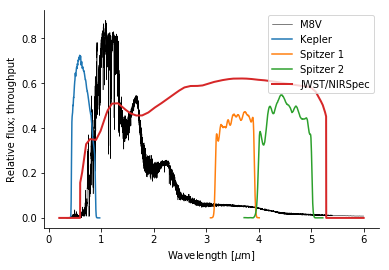

In [29]:
from scipy.ndimage import gaussian_filter1d

fig, ax = plt.subplots()
ax.plot(phoenix_wavelength/1000, gaussian_filter1d(trappist1_flux, 50), color='k', label='M8V', lw=0.5)
ax.plot(kplr_wavelength/1000, kplr_trans, label='Kepler')
ax.plot(spitz1_wave/1000, spitz1_trans, label='Spitzer 1')
ax.plot(spitz2_wave/1000, spitz2_trans, label='Spitzer 2')

ax.plot(phoenix_wavelength/1000, throughput(phoenix_wavelength/1000), label='JWST/NIRSpec', lw=2)
ax.legend()
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel('Relative flux; throughput')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.xlim([200, 6000])
#fig.savefig('i_love_nirspec.pdf', bbox_inches='tight')

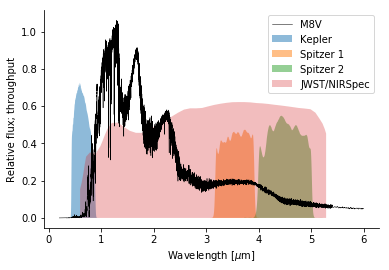

In [30]:
from scipy.ndimage import gaussian_filter1d

fig, ax = plt.subplots()
ax.plot(phoenix_wavelength/1000, phoenix_wavelength/1000 * gaussian_filter1d(trappist1_flux, 50), color='k', label='M8V', lw=0.5)
ax.fill_between(kplr_wavelength/1000, 0, kplr_trans, label='Kepler', alpha=0.5)
ax.fill_between(spitz1_wave/1000, 0, spitz1_trans, label='Spitzer 1', alpha=0.5)
ax.fill_between(spitz2_wave/1000, 0, spitz2_trans, label='Spitzer 2', alpha=0.5)
ax.fill_between(phoenix_wavelength/1000, throughput(phoenix_wavelength/1000), 
                label='JWST/NIRSpec', lw=2, alpha=0.3)
ax.legend()
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel('Relative flux; throughput')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.xlim([200, 6000])
#fig.savefig('i_love_nirspec.pdf', bbox_inches='tight')
#fig.savefig('i_love_nirspec.png', bbox_inches='tight', dpi=250)

In [31]:
temperature_offsets = np.linspace(-500, 2000, 10)
kepler_contrast_simple = []
spitzer_contrast_simple = []
for temp_offset in temperature_offsets:
    kplr_trans_interp = np.interp(phoenix_wavelength, kplr_wavelength, kplr_trans, left=0, right=0)
    photosphere_flux_kepler = np.trapz(trappist1_flux * phoenix_wavelength * kplr_trans_interp, phoenix_wavelength)
    bb_trial = blackbody_lambda(phoenix_wavelength, 2559 + temp_offset).value
    brightspot_flux = trappist1_flux * bb_trial / bb_2559.value 
    brightspot_flux_kepler = np.trapz(brightspot_flux * phoenix_wavelength * kplr_trans_interp, phoenix_wavelength)

    kepler_contrast_simple.append(brightspot_flux_kepler/photosphere_flux_kepler)

    spitzer_trans_interp = np.interp(phoenix_wavelength, spitz2_wave, spitz2_trans, left=0, right=0)
    photosphere_flux_spitzer = np.trapz(trappist1_flux * phoenix_wavelength * spitzer_trans_interp, phoenix_wavelength)
    brightspot_flux_spitzer = np.trapz(brightspot_flux * phoenix_wavelength * spitzer_trans_interp, phoenix_wavelength)

    spitzer_contrast_simple.append(brightspot_flux_spitzer / photosphere_flux_spitzer)

# plt.plot(phoenix_wavelength, trappist1_flux)
# plt.plot(phoenix_wavelength, brightspot_flux, ls='--')
# # plt.plot(phoenix_wavelength, bb_trial)
# # plt.plot(phoenix_wavelength, bb_2559)
# plt.plot(kplr_wavelength, kplr_trans)
# plt.plot(spitz1_wave, spitz1_trans)
# plt.plot(spitz2_wave, spitz2_trans)

In [32]:
temperature_offsets[np.argmin(np.abs(np.array(kepler_contrast) - 21))] + 2559

4281.2222222222226

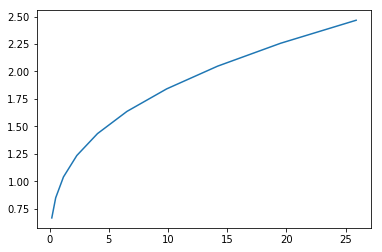

In [33]:
plt.plot(kepler_contrast_simple, spitzer_contrast_simple)

In [9]:
# temperature_offsets = np.linspace(-500, 2000, 10)
# kepler_contrast = []
# spitzer_contrast = []
# trappist1_flux_bb = blackbody_lambda(phoenix_wavelength, 2559).value
# for temp_offset in temperature_offsets:
#     kplr_trans_interp = np.interp(phoenix_wavelength, kplr_wavelength, kplr_trans, left=0, right=0)
#     photosphere_flux_kepler = np.trapz(trappist1_flux_bb * phoenix_wavelength * kplr_trans_interp, phoenix_wavelength)
#     bb_trial = blackbody_lambda(phoenix_wavelength, 2559 + temp_offset).value
#     brightspot_flux = trappist1_flux_bb * bb_trial / bb_2559.value 
#     brightspot_flux_kepler = np.trapz(brightspot_flux * phoenix_wavelength * kplr_trans_interp, phoenix_wavelength)

#     kepler_contrast.append(brightspot_flux_kepler/photosphere_flux_kepler)

#     spitzer_trans_interp = np.interp(phoenix_wavelength, spitz2_wave, spitz2_trans, left=0, right=0)
#     photosphere_flux_spitzer = np.trapz(trappist1_flux_bb * phoenix_wavelength * spitzer_trans_interp, phoenix_wavelength)
#     brightspot_flux_spitzer = np.trapz(brightspot_flux * phoenix_wavelength * spitzer_trans_interp, phoenix_wavelength)

#     spitzer_contrast.append(brightspot_flux_spitzer / photosphere_flux_spitzer)
    
# plt.plot(kepler_contrast, spitzer_contrast)

In [10]:
# from astropy.utils.data import download_file

# def get_phoenix_model_wavelengths(cache=True):
#     """
#     Return the wavelength grid that the PHOENIX models were computed on,
#     transformed into wavelength units in air (not vacuum).
#     """
#     wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/'
#                       'HiResFITS/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
#     wavelength_path = download_file(wavelength_url, cache=cache, timeout=30)
#     wavelengths_vacuum = fits.getdata(wavelength_path)

#     # Wavelengths are provided at vacuum wavelengths. For ground-based
#     # observations convert this to wavelengths in air, as described in
#     # Husser 2013, Eqns. 8-10:
#     sigma_2 = (10**4 / wavelengths_vacuum)**2
#     f = (1.0 + 0.05792105/(238.0185 - sigma_2) + 0.00167917 /
#          (57.362 - sigma_2))
#     wavelengths_air = wavelengths_vacuum / f
#     return wavelengths_air

# wavelengths = get_phoenix_model_wavelengths()


In [11]:
from glob import glob

paths = glob('/Users/bmmorris/git/freckles/data/lte*BT-Settl.spec.fits')

In [79]:
from astropy.io import fits

wavelengths = fits.getdata(paths[0])['Wavelength']

temperatures = []
model_fluxes = []

for path in paths:
    hdu = fits.open(path)
    temperatures.append(hdu[1].header['PHXTEFF'])
    interp_flux = np.interp(wavelengths, hdu[1].data['Wavelength'], hdu[1].data['Flux'])
    model_fluxes.append(interp_flux)
    
model_fluxes = np.vstack(model_fluxes)
temperatures = np.array(temperatures)

In [78]:
temperatures

array([2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100,
       3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200,
       4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300,
       5400, 5500])

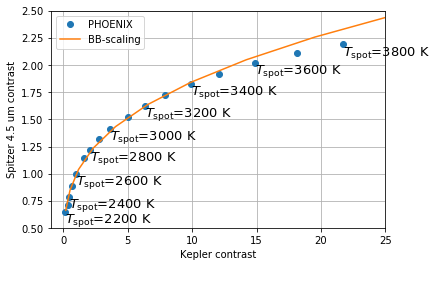

In [98]:

trappist1_flux = model_fluxes[np.argmin(np.abs(temperatures-2600)), :]

temperature_offsets = np.arange(-400, 3000, 100)

kepler_contrast = []
spitzer_contrast = []

for temp_offset in temperature_offsets:
    spot_flux = model_fluxes[np.argmin(np.abs(temperatures - (2600 + temp_offset))), :]
    
    kplr_trans_interp = np.interp(wavelengths, kplr_wavelength/1000, kplr_trans, left=0, right=0)
    photosphere_flux_kepler = np.trapz(trappist1_flux * wavelengths * kplr_trans_interp, wavelengths)
    spot_flux_kepler = np.trapz(spot_flux * wavelengths * kplr_trans_interp, wavelengths)

    kepler_contrast.append(spot_flux_kepler/photosphere_flux_kepler)
    
    spitzer_trans_interp = np.interp(wavelengths, spitz2_wave/1000, spitz2_trans, left=0, right=0)
    photosphere_flux_spitzer = np.trapz(trappist1_flux * wavelengths * spitzer_trans_interp, wavelengths)
    spot_flux_spitzer = np.trapz(spot_flux * wavelengths * spitzer_trans_interp, wavelengths)

    spitzer_contrast.append(spot_flux_spitzer / photosphere_flux_spitzer)

#     plt.figure()
#     plt.plot(wavelengths, trappist1_flux*wavelengths/np.max(trappist1_flux*wavelengths))
#     plt.plot(wavelengths, brightspot_flux*wavelengths/np.max(brightspot_flux*wavelengths))
#     plt.plot(wavelengths, kplr_trans_interp)
#     plt.plot(wavelengths, spitzer_trans_interp)
#     plt.show()
    
temperatures_tested = 2600 + temperature_offsets
plt.plot(kepler_contrast, spitzer_contrast, 'o', label='PHOENIX')

for k, s, t in zip(kepler_contrast[::2], spitzer_contrast[::2], temperatures_tested[::2]):
    plt.annotate("$T_{{\mathrm{{spot}}}}$={0} K".format(t), 
                 xy=(k, s), xytext=(k, s), fontsize=13, va='top')

plt.plot(kepler_contrast_simple, spitzer_contrast_simple, label='BB-scaling')
plt.xlabel('Kepler contrast')
plt.ylabel('Spitzer 4.5 um contrast')
plt.legend()
plt.xlim([-1, 25])
plt.ylim([0.5, 2.5])
plt.grid()
plt.savefig('kepler_spitzer_contrasts.pdf')

3784.24986455 8.13932484468


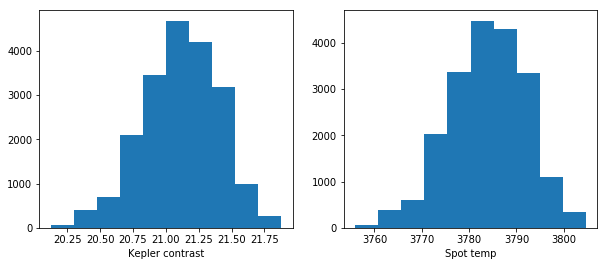

In [97]:
samples = np.loadtxt('posteriors_bright_spot.txt')
contrasts = samples[:, -1]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(contrasts)
ax[0].set(xlabel='Kepler contrast')

temperatures_inferred = np.interp(contrasts, kepler_contrast, temperatures_tested)
ax[1].hist(temperatures_inferred)

print(np.median(temperatures_inferred), np.std(temperatures_inferred))
ax[1].set(xlabel='Spot temp')
fig.savefig('bright_spot_posteriors_temp.pdf')

In [14]:
# from scipy.interpolate import RectBivariateSpline

# spline_order = 1
# rbs = RectBivariateSpline(wavelengths,
#                           temperatures,
#                           model_fluxes.T,
#                           kx=spline_order,
#                           ky=spline_order)

# def get_spectrum(teff):
#     return rbs.ev(wavelengths, teff)
# consider_wavelengths = wavelengths[(wavelengths > 0.2) & (wavelengths < 6)]
# temperature_offsets = np.linspace(-500, 2000, 3)
# kepler_contrast = []
# spitzer_contrast = []

# trappist1_flux = get_spectrum(2559)

# for temp_offset in temperature_offsets:
#     print(temp_offset)
#     kplr_trans_interp = np.interp(consider_wavelengths, kplr_wavelength/1000, kplr_trans, left=0, right=0)
#     photosphere_flux_kepler = np.trapz(trappist1_flux_bb * wavelengths * kplr_trans_interp, consider_wavelengths)

#     brightspot_flux = get_spectrum(2559 + temp_offset)
#     brightspot_flux_kepler = np.trapz(brightspot_flux * consider_wavelengths * kplr_trans_interp, consider_wavelengths)

#     kepler_contrast.append(brightspot_flux_kepler/photosphere_flux_kepler)

#     spitzer_trans_interp = np.interp(phoenix_wavelength, spitz2_wave/1000, spitz2_trans, left=0, right=0)
#     photosphere_flux_spitzer = np.trapz(trappist1_flux * consider_wavelengths * spitzer_trans_interp, consider_wavelengths)
#     brightspot_flux_spitzer = np.trapz(brightspot_flux * consider_wavelengths * spitzer_trans_interp, consider_wavelengths)

#     spitzer_contrast.append(brightspot_flux_spitzer / photosphere_flux_spitzer)
    
# plt.plot(kepler_contrast, spitzer_contrast)